# Quantum Teleportation Protocol

## Teleporting a single qubit - Real quantum copmuters

In [49]:
import numpy as np
from qiskit import ClassicalRegister, QuantumRegister, QuantumCircuit
from qiskit import transpile
from qiskit.result import Counts, marginal_counts
from qiskit.visualization import array_to_latex, plot_histogram, plot_bloch_multivector
from qiskit.extensions import Initialize
from qiskit.quantum_info import random_statevector, Statevector
from qiskit.providers.aer import StatevectorSimulator, QasmSimulator

In [50]:
def create_random_data_qubit(dimensions: int) -> Statevector:
    return random_statevector(dimensions)

In [51]:
def create_bell_pair(qc: QuantumCircuit, a: QuantumRegister, b: QuantumRegister) -> None:
    qc.barrier()
    qc.h(a)
    qc.cx(a, b)

In [52]:
def bell_state_operation(qc: QuantumCircuit, d: QuantumRegister, a: QuantumRegister) -> None:
    qc.barrier()
    qc.cx(d, a)
    qc.h(d)

In [53]:
def pauli_correction_operation(qc: QuantumCircuit, d: QuantumRegister, a: QuantumRegister, b: QuantumRegister) -> None:
    qc.barrier()
    qc.cx(a, b)
    qc.cz(d, b)

In [54]:
data: QuantumRegister = QuantumRegister(1, "data")

alice: QuantumRegister = QuantumRegister(1, "alice")
bob: QuantumRegister = QuantumRegister(1, "bob")

# crz: ClassicalRegister = ClassicalRegister(1, "crz")
# crx: ClassicalRegister = ClassicalRegister(1, "crx")

coz: ClassicalRegister = ClassicalRegister(1, "coz")

qc: QuantumCircuit = QuantumCircuit(data, alice, bob, coz)

<IPython.core.display.Latex object>

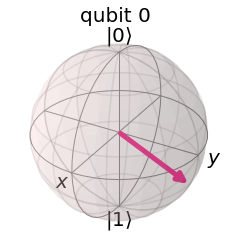

In [55]:
psi: Statevector = create_random_data_qubit(2)
display(array_to_latex(psi, prefix="|\\psi\\rangle = "))
plot_bloch_multivector(psi)

In [56]:
init_instruction: Initialize = Initialize(psi)
init_instruction.label = "init instruction"

qc.append(init_instruction, data)

In [57]:
create_bell_pair(qc, alice, bob)

In [58]:
bell_state_operation(qc, data, alice)

In [59]:
pauli_correction_operation(qc, data, alice, bob)

In [60]:
inverse_init_instruction: Initialize = init_instruction.gates_to_uncompute()

qc.barrier()
qc.append(inverse_init_instruction, bob)

In [61]:
qc.barrier()

qc.measure(bob, coz)

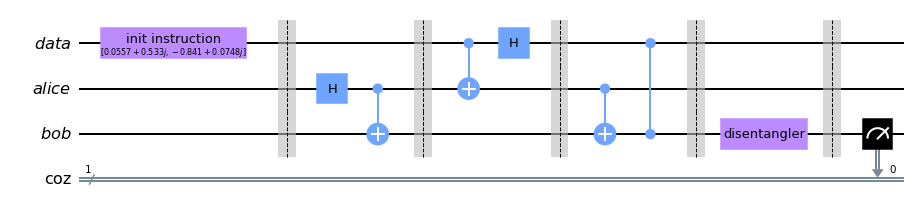

In [62]:
qc.draw("mpl")

## Executing

In [63]:
# First, see what devices we are allowed to use by loading our saved accounts
IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q')

ibmqfactory.load_account:WARNING:2022-09-15 10:55:06,008: Credentials are already in use. The existing account in the session will be replaced.


In [64]:
# get the least-busy backend at IBM and run the quantum circuit there
from qiskit.providers.ibmq import least_busy
from qiskit.tools.monitor import job_monitor

backend = least_busy(provider.backends(filters=lambda b: b.configuration().n_qubits >= 3 and
                                   not b.configuration().simulator and b.status().operational==True))
t_qc = transpile(qc, backend, optimization_level=3)
job = backend.run(t_qc)
job_monitor(job)  # displays job status under cell

Job Status: job has successfully run


{'0': 3460, '1': 540}


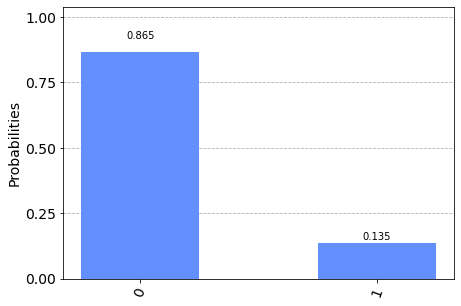

In [65]:
# Get the results and display them
exp_result = job.result()
exp_counts: Counts = exp_result.get_counts(qc)
print(exp_counts)
plot_histogram(exp_counts)

In [69]:
print(f"The experimental error rate : {exp_counts['1']*100/sum(exp_counts.values()):.3f}%")

The experimental error rate : 13.500%
